In [66]:
import os,sys, yaml
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from langchain_community.document_loaders import PyMuPDFLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.vectorstores import Chroma
from langchain_community.llms import Ollama
from langchain_core.prompts import ChatPromptTemplate
import numpy as np

embed_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


/Users/sandhyasangli/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [67]:
import yaml, torch
with open("config.yaml", 'r') as f:
    cfg = yaml.safe_load(f)

def read_file(filename):
    loader = PyMuPDFLoader(filename)
    return loader.load()

# Character based chunking
def split_document_char_based(filename):
    data = read_file(filename)
    text_splitter = CharacterTextSplitter(
            chunk_size=cfg['TEXT_SPLITTER']['chunk_size'],
            chunk_overlap=cfg['TEXT_SPLITTER']['chunk_overlap'],
            separator="\n",
            )
    docs = []
    for d in data:
        docs.append(d.page_content)
    return text_splitter.split_text(' '.join(docs))

# Sentence based chunking
def split_document_on_sentence(filename):
    data = read_file(filename)
    docs = []
    for d in data:
        content = d.page_content
        for sent in sent_tokenize(content):
            docs.append(sent)
    return docs

def generate_embeddings(embed_model, data):
    #docs = split_document_char_based(filename)
    embeddings = []
    for d in data:
        embeddings.append(embed_model.encode(d))
    return torch.tensor(embeddings)

def cosine_similarity(embeddings, query_embeddings):
    cosine_similarity ={}
    for i, emb in enumerate(embeddings):
        dot_product = np.dot(emb, query_embeddings)
        norm_a = np.linalg.norm(emb)
        norm_b = np.linalg.norm(query_embeddings)
        cosine_similarity[i] = dot_product / (norm_a * norm_b)
    return cosine_similarity

def euclidean_similarity(embeddings, query_embeddings):
    euc_dist = {}
    for i, emb in enumerate(embeddings):
        euc_dist[i] = np.linalg.norm(emb - query_embeddings)
    return euc_dist

def similarity_search(embeddings, query_embeddings, type="cosine", top_k = 3):
    if type=="cosine":
        result = cosine_similarity(embeddings, query_embeddings)  
        top_k_sorted = sorted(result.items(), key = lambda x : x[1], reverse=True)[:top_k]
    else:
        result = euclidean_similarity(embeddings, query_embeddings)
        top_k_sorted = sorted(result.items(), key=lambda x : x[1])[:top_k]
    return [x[0] for x in top_k_sorted]

def get_similar_docs(data, embeddings, similar_docs_idx):
    for idx in similar_docs_idx:
        print("------------{}-----------".format(idx))
        print(data[idx])

def generate_context(data_chunks, embeddings, query_embeddings, search_type="cosine", top_k=3):
    similar_doc_indices = [similarity_search(embeddings, query_embeddings, search_type, top_k)]
    context = []
    for idx in similar_doc_indices:
        context.append(data_chunks[idx[0]])
    return ' '.join(context)

def process_document(data):
    punctuation = string.punctuation
    stop_words = stopwords.words('english')
    # first split by sentences
    sentences = []
    for sentence in sent_tokenize(data):
        mod_sentence = []
        for word in word_tokenize(sentence):
            word = word.lower()
            if not word.isalpha() or word in stop_words or word in punctuation:
                continue
            mod_sentence.append(word)
        sentences.append(' '.join(mod_sentence))
    return sentences


Generate Embeddings

In [3]:
chunks_by_char = split_document_char_based("batch_normalization.pdf")
chunks_by_sent = split_document_on_sentence("batch_normalization.pdf")
char_embeddings = generate_embeddings(embed_model, chunks_by_char)
sent_embeddings = generate_embeddings(embed_model, chunks_by_sent)

/var/folders/s7/nsvqzd050512zsxdfsllv8740000gn/T/ipykernel_1363/3948116586.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025535429/work/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(embeddings)


In [8]:
query = "What is the topic of this document?"
q_emb = embed_model.encode(query)

In [9]:
context_for_chunk_by_char = generate_context(chunks_by_char, char_embeddings, q_emb)
context_for_chunk_by_sent = generate_context(chunks_by_sent, sent_embeddings, q_emb)

In [329]:
print("-------- Context : Char chunking ----------")
print(context_for_chunk_by_char)

-------- Context : Char chunking ----------
pair of parameters γ(k) and β(k) per feature map, rather
than per activation. Alg. 2 is modiﬁed similarly, so that
during inference the BN transform applies the same linear
transformation to each activation in a given feature map.
3.3
Batch Normalization enables higher
learning rates
In traditional deep networks, too-high learning rate may
result in the gradients that explode or vanish, as well as
getting stuck in poor local minima.
Batch Normaliza-
tion helps address these issues. By normalizing activa-
tions throughout the network, it prevents small changes
to the parameters from amplifying into larger and subop-
timal changes in activations in gradients; for instance, it
prevents the training from getting stuck in the saturated
regimes of nonlinearities.
Batch Normalization also makes training more resilient
to the parameter scale. Normally, large learning rates may
increase the scale of layer parameters, which then amplify
the gradient du

In [10]:
print("-------- Context : Sentence chunking ----------")
print(context_for_chunk_by_sent)

-------- Context : Sentence chunking ----------
ISSN 1532-4435.


In [16]:
llm = Ollama(model="llama3")

In [20]:
print(llm)
llm.invoke("Why is Sky blue?")

Ollama
Params: {'model': 'llama3', 'format': None, 'options': {'mirostat': None, 'mirostat_eta': None, 'mirostat_tau': None, 'num_ctx': None, 'num_gpu': None, 'num_thread': None, 'num_predict': None, 'repeat_last_n': None, 'repeat_penalty': None, 'temperature': None, 'stop': None, 'tfs_z': None, 'top_k': None, 'top_p': None}, 'system': None, 'template': None, 'keep_alive': None}


"Sky isn't actually blue. The sky appears blue to us because of the way that light scatters in the Earth's atmosphere.\n\nWhen sunlight enters the Earth's atmosphere, it encounters tiny molecules of gases such as nitrogen (N2) and oxygen (O2). These molecules scatter the light in all directions, but they do it in a way that favors shorter wavelengths, like blue and violet. This is known as Rayleigh scattering, named after the British physicist Lord Rayleigh who first described the phenomenon.\n\nThe shorter wavelengths of light are scattered more than the longer wavelengths, like red and orange. This is why the sky typically appears blue during the daytime, especially in the direction perpendicular to the sun. The blue color is most intense when the sun is overhead, which is why the sky often seems more vibrant at noon.\n\nAt sunrise and sunset, the sun's rays have to travel longer distances through the atmosphere, which scatters even more of the shorter wavelengths. This is why the sk

In [25]:
data = read_file("batch_normalization.pdf")

In [32]:
all_content = ""
for d in data:
    all_content += d.page_content

In [33]:
prompt_template = """You are good at asking questions relevant to {data}. Can you list the top 5 questions that you would ask?"""
prompt = ChatPromptTemplate.from_template(prompt_template)
chain = prompt | llm
#print(context)
print(chain.invoke({"query" : query, "data" : all_content}))

A chance to dig into some deep learning research!

Here are the top 5 questions I'd ask based on arXiv:1502.03167:

1. **What motivated the changes in the Inception architecture compared to GoogLeNet?** The paper presents a variant of the Inception model, but it's not immediately clear why these specific changes were made. Were they driven by computational constraints, accuracy concerns, or some other factor?
2. **How do the separable convolutional layers with depth multiplier 8 impact training time and memory consumption?** The use of separable convolutions is an interesting approach to reducing computational costs while maintaining performance. I'd like to know more about their effect on the overall training process.
3. **What are the trade-offs between the increased maximum depth, number of parameters, and computational cost resulting from replacing 5×5 convolutional layers with two consecutive 3×3 layers?** This change seems significant, but what were the consequences for training 

In [34]:
# Create prompt and invoke llm

prompt_template = """you are excellent at summarizing document {data}."""
prompt = ChatPromptTemplate.from_template(prompt_template)
chain = prompt | llm


In [36]:
print("------------LLM response -------------")
print(chain.invoke ({"query": "summarize", "data" : all_content}))

------------LLM response -------------
A summary of a research paper on deep learning!

Here's a brief overview:

**Paper:** "A Convergence Analysis of Log-Linear Training" by Simon et al. (2011) and "Mean-Normalized Stochastic Gradient for Large-Scale Deep Learning" by Wiesler et al. (2014)

**Context:** The papers explore the convergence analysis of log-linear training in deep neural networks, which is essential for large-scale image recognition tasks.

**Summary:**

The first paper presents a convergence analysis of log-linear training in deep neural networks, demonstrating that it converges to a globally optimal solution under certain conditions. This analysis is crucial for understanding the behavior of large-scale deep learning models.

The second paper proposes a mean-normalized stochastic gradient method for training deep neural networks on large datasets. The approach improves the stability and convergence rate of the optimization process, making it more suitable for large-sca

Based on the LLM response, it is clear that more the information sent to LLM, better will be the result. Both character level and sentence level chunking is giving good answers but since sentence based chunking has overall less information compared to character level chunking, the result from LLM is also concise.

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

processed_content = process_document(all_content)

In [42]:
tfidf = TfidfVectorizer()
vectorizer = tfidf.fit_transform(processed_content)


In [62]:
matrix = vectorizer.toarray()
feature_names = tfidf.get_feature_names_out()
len(feature_names)
matrix.shape

(372, 1226)

In [65]:
#print(feature_names)
doc = 2
first_doc = matrix[doc, :].nonzero()
for i in first_doc:
    for n, s in zip(feature_names[i], matrix[doc, i]):
        print(n, s)

address 0.349096403691236
covariate 0.27689921717018784
internal 0.27689921717018784
layer 0.21936629097225357
normalizing 0.2972815790280928
phenomenon 0.40931201711462734
problem 0.33711483059357916
puts 0.349096403691236
refer 0.349096403691236
shift 0.2517302259278154


In [335]:
query1 = "Why are the disadvantages of Batch Normalization?"
context = generate_context(chunks_by_char, char_embeddings, embed_model.encode(query1))
print("--------------Context---------------")
print(chain.invoke({"query" : query1,
                    "context" : context}))

--------------Context---------------
Here are some disadvantages of Batch Normalization with chunk pair of parameters γ(k) and β(k) per feature map:

**Disadvantages:**

• **Computational Cost:** Batch Normalization requires computing statistical values (mean and variance) for each feature map, which can be computationally expensive.

• **Memory Requirements:** The algorithm needs to store the batch statistics, which can increase memory requirements.

• **Overfitting:** Although Batch Normalization helps with generalization, it can also introduce overfitting if the batch size is too small or if the model is complex enough.

• **Interpretable Models:** Since each feature map has its own normalization parameters γ(k) and β(k), it may be more challenging to interpret the learned features.

• **Scalability:** Batch Normalization might not scale well with very large models or datasets, as computing statistics for each feature map can become too computationally expensive.

Let me know if you

In [12]:

%pip install arxiv
%pip install arxiv2text

Note: you may need to restart the kernel to use updated packages.
  Using cached pdfminer.six-20240706-py3-none-any.whl.metadata (4.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 30.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [13]:
import requests, PyPDF2, io
url ="https://arxiv.org/pdf/1502.03167"

def read_pdf_url(url):
    response = requests.get(url)
    pdf_file = io.BytesIO(response.content)
    pdf_reader = PyPDF2.PdfReader(pdf_file)
    # Extract text
    text = ""
    for page in pdf_reader.pages:
        text += page.extract_text()
    return text

def split_document_char_based_v1(data):
    text_splitter = CharacterTextSplitter(
            chunk_size=cfg['TEXT_SPLITTER']['chunk_size'],
            chunk_overlap=cfg['TEXT_SPLITTER']['chunk_overlap'],
            separator="\n",
            )
    return text_splitter.split_text(data)

In [31]:
type(text)

str

In [4]:
url = "https://arxiv.org/pdf/1603.09320"
data = read_pdf_url(url)

In [12]:
len(data), type(data)

(70823, str)

In [14]:
data_chunks= split_document_char_based_v1(data)

In [15]:
len(data_chunks)

84

In [19]:
data_chunks[0]

'IEEE TRANSACTIONS ON  JOURNAL NAME,  MANUS CRIPT ID  1 \n Efficient and robust approximate nearest \nneighbor search using Hierarchical Navigable \nSmall World graphs  \nYu. A. Malkov,  D. A. Yashunin  \nAbstract  — We present a new approach for the approximate K -nearest neighbor search based on navigable small world \ngraphs with controllable hierarchy (Hierarchical NSW , HNSW ). The proposed solution is fully graph -based, without any need for \nadditional search structures, which are typically used at the coarse search stage of the most proximity graph techniques. \nHierarchical NSW incrementally builds  a multi -layer structure consisting from hierarchical set of proximity graphs (layers) for \nnested  subsets of the stored elements. The maximum layer in which an element is present is selected randomly with an \nexponentially decaying probability distribution. This allows producing graphs similar to the previously studied Navigable Sma ll'

In [18]:
embeddings = generate_embeddings(embed_model, data_chunks)

/var/folders/s7/nsvqzd050512zsxdfsllv8740000gn/T/ipykernel_62596/3948116586.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025535429/work/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(embeddings)


In [76]:
prompt_template = """you are excellent at summarizing scientific document {data}.
Summary should be in the format of 
1. What is the problem statement?
2. What is the existing method?
3. What is the proposed solution and how is it different from the existing one?
4. Include any experimental result like table or images.
5. What is the conclusion?
"""
prompt = ChatPromptTemplate.from_template(prompt_template)
chain = prompt | llm
print(chain.invoke({"data" : data}))

Based on the provided documents, I'll summarize the content as follows:

**Document 1: Page 9**

1. **Problem Statement**: The problem statement is not explicitly mentioned in this document.
2. **Existing Method**: Not applicable.
3. **Proposed Solution and its differences from existing one**: Not applicable.
4. **Experimental Results**: No experimental results are provided in this document.

**Document 2: Page 10**

1. **Problem Statement**: The problem statement is not explicitly mentioned in this document either.
2. **Existing Method**: Not applicable.
3. **Proposed Solution and its differences from existing one**: This document appears to describe a neural network architecture called Inception, which is designed for image classification tasks. The proposed solution is a multi-layer convolutional network with multiple layers of inception modules, each consisting of parallel branches of different sizes.
4. **Experimental Results**:

The document provides a table (Figure 5) illustrati

In [71]:
len(data)

11

In [72]:
content = ""
for d in data:
    content += d.page_content
    

In [77]:
print(chain.invoke({"data" :content}))

Here's a summary of the scientific document in the format you requested:

**1. Problem Statement:**
The problem statement is to improve the performance of large-scale deep learning models, particularly in image recognition tasks.

**2. Existing Method:**
The existing method referred to is the GoogLeNet architecture, which was introduced by Szegedy et al. (2014). The original model consisted of 28×28 inception modules with average and maximum-pooling layers, as well as 5×5 convolutional layers.

**3. Proposed Solution:**
The proposed solution is a variant of the Inception model that modifies the architecture to improve performance and efficiency. The key changes are:

* Replacing 5×5 convolutional layers with two consecutive 3×3 convolutional layers, which increases the maximum depth of the network and number of parameters.
* Increasing the number of inception modules from 2 to 3.
* Employing average and maximum-pooling layers within the inception modules.
* Using stride-2 convolution/p

In [75]:
data[0].metadata

{'source': 'batch_normalization.pdf',
 'file_path': 'batch_normalization.pdf',
 'page': 0,
 'total_pages': 11,
 'format': 'PDF 1.4',
 'title': '',
 'author': '',
 'subject': '',
 'keywords': '',
 'creator': 'LaTeX with hyperref package',
 'producer': 'dvips + GPL Ghostscript GIT PRERELEASE 9.08',
 'creationDate': "D:20150302203121-05'00'",
 'modDate': "D:20150302203121-05'00'",
 'trapped': ''}

In [78]:
prompt_template1 = """
Could you please provide a concise and comprehensive summary of the given text? The summary should capture the main points and key details of the text while conveying the author's intended meaning accurately. Please ensure that the summary is well-organized and easy to read, with clear headings and subheadings to guide the reader through each section. The length of the summary should be appropriate to capture the main points and key details of the text, without including unnecessary information or becoming overly long.
Document : {document}
"""

In [79]:
prompt = ChatPromptTemplate.from_template(prompt_template1)
chain = prompt | llm

In [80]:
print(chain.invoke({"document": content}))

Here is a concise and comprehensive summary of the text:

The provided text appears to be an appendix or supplementary material for a research paper on deep learning. The main topic discussed is the architecture of the Inception Model, specifically the variant used in this study.

The text begins by describing changes made to the GoogleNet architecture to create the new model. These changes include replacing 5x5 convolutional layers with two consecutive 3x3 layers, increasing the number of inception modules from 2 to 3, and employing average or maximum-pooling within some modules.

The rest of the text presents a table (Figure 5) documenting the architecture of the Inception Model used in this study. The table shows the type of layer, patch size/stride, output size, depth, and number of layers for each module.

The notable features of the model include:

* Separable convolution with a depth multiplier of 8 on the first convolutional layer to reduce computational cost while increasing m

In [83]:
!pip install transformers==2.2.0
!pip install bert-extractive-summarizer


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for transformers==2.2.0 from https://files.pythonhosted.org/packages/ec/e7/0a1babead1b79afabb654fbec0a052e0d833ba4205a6dfd98b1aeda9c82e/transformers-2.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for boto3 from https://files.pythonhosted.org/packages/94/83/81c3d2199f2196493b1f67852e6361a082ca05dc5d976432b86808b7db82/boto3-1.35.54-py3-none-any.whl.metadata
  Obtaining dependency information for sentencepiece from https://files.pythonhosted.org/packages/de/42/ae30952c4a0bd773e90c9bf2579f5533037c886dfc8ec68133d5694f4dd2/sentencepiece-0.2.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for sacremoses from https://files.pythonhosted.org/packages/0b/f0/89ee2bc9da434bd78464f288fdb346bc2932f2ee80a90b2a4bbbac262c74/sacremoses-0.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for botocore<1.36.0,>=1.35.54 from https://files.pythonhosted.org/packages/f2/cd/e79c87014d0ed371335273cbf8a2bc1fdd6dd2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ModuleNotFoundError: No module named 'summarizer'

In [89]:
prompt_template2 = """
Can you extract the metadata from the document : {document} ?
"""
prompt = ChatPromptTemplate.from_template(prompt_template2)
chain =prompt | llm

In [90]:
print(chain.invoke({"document": content}))

Here is the extracted metadata from the document:

* arXiv ID: 150
* Authors:
	+ Simon, Wiesler, Richard, Alexander, Schluter, Ralf, and Ney, Hermann
	+ Wu, Ren, Yan, Shengen, Shan, Yi, Dang, Qingqing, and Sun, Gang (in the reference)
* Title: None provided
* Conference proceedings:
	+ Advances in Neural Information Processing Systems 24, pp. 657–665, Granada, Spain, December 2011
	+ IEEE International Conference on Acoustics, Speech, and Signal Processing, pp. 180–184, Florence, Italy, May 2014
* Reference:
	+ Szegedy et al., 2014 (consulted for the interpretation of Figure 5)

Let me know if you need any further assistance!


In [91]:
data[0].metadata

{'source': 'batch_normalization.pdf',
 'file_path': 'batch_normalization.pdf',
 'page': 0,
 'total_pages': 11,
 'format': 'PDF 1.4',
 'title': '',
 'author': '',
 'subject': '',
 'keywords': '',
 'creator': 'LaTeX with hyperref package',
 'producer': 'dvips + GPL Ghostscript GIT PRERELEASE 9.08',
 'creationDate': "D:20150302203121-05'00'",
 'modDate': "D:20150302203121-05'00'",
 'trapped': ''}

In [95]:
metadata = []
for d in data:
    metadata.append(d.metadata)
    

In [96]:
metadata

[{'source': 'batch_normalization.pdf',
  'file_path': 'batch_normalization.pdf',
  'page': 0,
  'total_pages': 11,
  'format': 'PDF 1.4',
  'title': '',
  'author': '',
  'subject': '',
  'keywords': '',
  'creator': 'LaTeX with hyperref package',
  'producer': 'dvips + GPL Ghostscript GIT PRERELEASE 9.08',
  'creationDate': "D:20150302203121-05'00'",
  'modDate': "D:20150302203121-05'00'",
  'trapped': ''},
 {'source': 'batch_normalization.pdf',
  'file_path': 'batch_normalization.pdf',
  'page': 1,
  'total_pages': 11,
  'format': 'PDF 1.4',
  'title': '',
  'author': '',
  'subject': '',
  'keywords': '',
  'creator': 'LaTeX with hyperref package',
  'producer': 'dvips + GPL Ghostscript GIT PRERELEASE 9.08',
  'creationDate': "D:20150302203121-05'00'",
  'modDate': "D:20150302203121-05'00'",
  'trapped': ''},
 {'source': 'batch_normalization.pdf',
  'file_path': 'batch_normalization.pdf',
  'page': 2,
  'total_pages': 11,
  'format': 'PDF 1.4',
  'title': '',
  'author': '',
  'subj

In [100]:
sent_embeddings.shape

torch.Size([382, 384])

In [103]:
from sklearn.cluster import KMeans


In [161]:
km = KMeans(n_clusters=8)


In [162]:
km.fit(sent_embeddings)

KMeans()

In [163]:
km.inertia_
km.cluster_centers_.shape

(8, 384)

In [110]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2)
x = pca.fit_transform(sent_embeddings)

In [111]:
x.shape

(382, 2)

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline

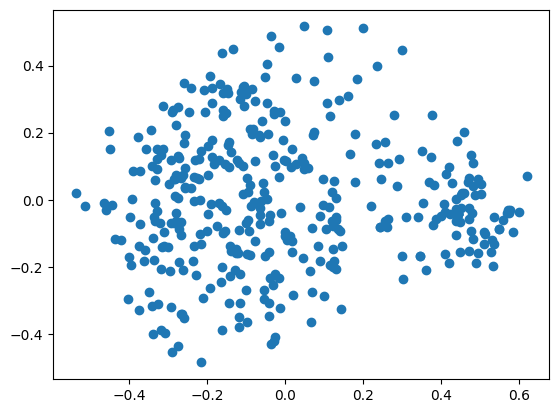

In [113]:
plt.scatter(x[:,0], x[:, 1])

In [115]:
km = KMeans(n_clusters=4)
x1 = km.fit_transform(x)

In [116]:
x1.shape

(382, 4)

In [117]:
km.cluster_centers_



array([[-0.17472293,  0.21427953],
       [ 0.45320776, -0.03338043],
       [-0.2229982 , -0.18313554],
       [ 0.08742201,  0.00754515]])

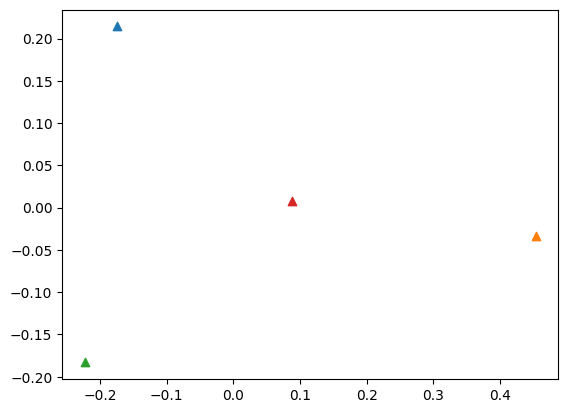

In [120]:
for centre in km.cluster_centers_:
    plt.scatter(centre[0], centre[1], marker="^")

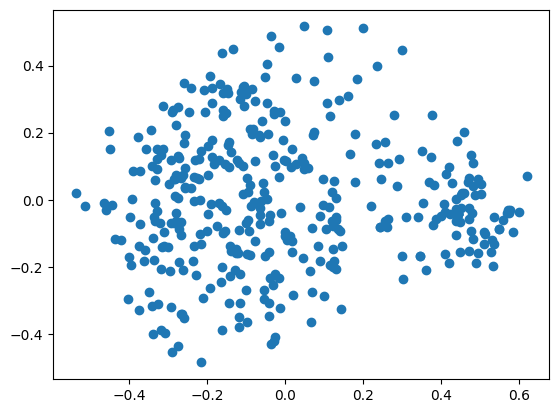

In [121]:
plt.scatter(x[:, 0], x[:, 1])

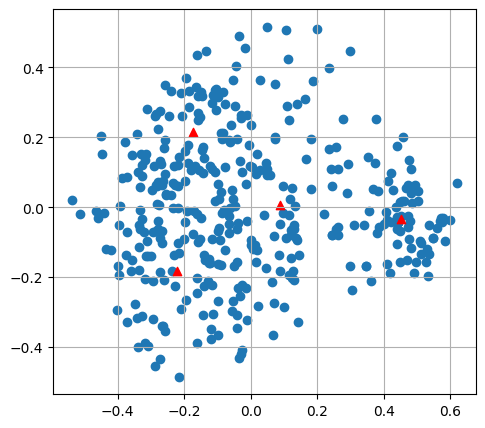

In [124]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(x[:,0],x[:,1])
plt.grid(True)
for center in km.cluster_centers_:

    plt.scatter(center[0],center[1],marker = '^',c = 'red')


In [125]:
# get sentences closer to the cluster centres
c1 = km.cluster_centers_[0]
c1

array([-0.17472293,  0.21427953])

In [131]:
np.sum(np.square(x[0] - c1))


0.1917363426749375

In [132]:
np.sum(np.square(x - c1))

74.53498543307457

In [138]:
for c in km.cluster_centers_:
    print(np.argmin(np.sum(x -c, axis= 1)))

44
44
44
44


In [139]:
c1 = km.cluster_centers_[0]

In [140]:
c1

array([ 0.45320776, -0.03338043])

In [141]:
c2 = km.cluster_centers_[1]

In [142]:
c2

array([ 0.45320776, -0.03338043])

In [145]:
for c in km.cluster_centers_:
    print(c)
    print(np.argmin(np.sum(x - c, axis= 1)))

[-0.17472293  0.21427953]
44
[ 0.45320776 -0.03338043]
44
[-0.2229982  -0.18313554]
44
[0.08742201 0.00754515]
44


In [147]:
c1 = km.cluster_centers_[2]

In [148]:
c1

array([-0.2229982 , -0.18313554])

In [155]:
np.argmin(np.sum(np.square(x - c2), axis=1))


140

In [156]:
len(chunks_by_sent)

382

In [158]:
chunks_by_sent[220]

'Because batch-\nnormalized networks train faster and observe each train-\ning example fewer times, we let the trainer focus on more\n“real” images by distorting them less.'

In [159]:
len(km.cluster_centers_)

4

In [164]:
km.cluster_centers_


array([[-0.03920212, -0.05626672,  0.03190423, ...,  0.01666498,
        -0.02245708, -0.0234887 ],
       [-0.02463121, -0.03792319,  0.01205767, ..., -0.00108457,
        -0.04867958, -0.05857859],
       [-0.04410766,  0.00923649, -0.03760194, ..., -0.01705548,
         0.00158782,  0.02663357],
       ...,
       [-0.06815619, -0.03128024,  0.00697434, ...,  0.03456394,
        -0.0202269 , -0.02818193],
       [-0.03013345, -0.02234102,  0.02085433, ...,  0.0029334 ,
        -0.01986995, -0.03821322],
       [-0.03931657, -0.0057368 , -0.01544802, ..., -0.00071975,
        -0.02159457,  0.00471513]])

In [165]:
c0 = km.cluster_centers_[0]

In [166]:
c0.shape

(384,)

In [172]:
type(sent_embeddings)

torch.Tensor

In [173]:
emb = sent_embeddings[0]

In [179]:
for emb in sent_embeddings:
    diff = np.sum(np.abs(emb.numpy() - c0))
    print(diff)

12.098505500459146
11.290385892850644
13.342009680128857
12.579076055072456
13.42371162086637
13.671358244600876
13.685986979280795
13.488489839052642
12.884676757947231
12.874043604934872
13.114988773386102
12.548756930028897
15.736995394348495
13.314735181690704
14.802967004265007
12.301961478187298
11.429660140044401
12.974538580401383
13.709174623895377
17.053259614932472
12.88650865955919
12.187551857856555
13.141880424817156
11.454213682810707
15.635096964057421
17.338179619702096
17.077536936146295
13.015587362477502
13.200958371250135
17.23328636977225
13.702238719869175
12.700907423778414
12.853963276255215
14.29202436662352
11.495563785818096
11.37240230013353
13.095780862260925
11.919596699118571
13.935604086619396
11.899204143839572
11.642052041531093
13.014749381879032
14.15577709499997
17.58867219320583
13.141296359266697
13.461696651339299
10.789523670037978
12.345213451745122
11.02744517037696
11.00469163730516
14.759481011750823
12.84352080392392
12.781267902254779
13.

In [185]:
def find_closest(centroid, sent_embeddings, k = 5):
    dist = []
    for idx, emb in enumerate(sent_embeddings):
        dist.append((np.sum(np.abs(emb.numpy() - centroid)), idx))
    return sorted(dist, key=lambda x : x[0])[:k]

In [183]:
top_5 = sorted(dist, key = lambda x : x[0])[:5]

In [184]:
for d in top_5:
    print(chunks_by_sent[d[1]])

This
ensures that as the model is training, layers can continue
learning on input distributions that exhibit less internal co-
variate shift, thus accelerating the training.
These sub-network
inputs all have ﬁxed means and variances, and although
the joint distribution of these normalized b
x(k) can change
over the course of training, we expect that the introduc-
tion of normalized inputs accelerates the training of the
sub-network and, consequently, the network as a whole.
2
Towards
Reducing
Internal
Covariate Shift
We deﬁne Internal Covariate Shift as the change in the
distribution of network activations due to the change in
network parameters during training.
The
resulting networks can be trained with saturating nonlin-
earities, are more tolerant to increased training rates, and
often do not require Dropout for regularization.
It has
been long known (LeCun et al., 1998b; Wiesler & Ney,
2011) that the network training converges faster if its in-
puts are whitened – i.e., linearly tr

In [188]:
context = ""
for c in km.cluster_centers_:
    top_5 = find_closest(c, sent_embeddings)
    print("---------centroid-----------")
    for id in top_5:
        print(chunks_by_sent[id[1]])
        context += chunks_by_sent[id[1]]

---------centroid-----------
This
ensures that as the model is training, layers can continue
learning on input distributions that exhibit less internal co-
variate shift, thus accelerating the training.
These sub-network
inputs all have ﬁxed means and variances, and although
the joint distribution of these normalized b
x(k) can change
over the course of training, we expect that the introduc-
tion of normalized inputs accelerates the training of the
sub-network and, consequently, the network as a whole.
2
Towards
Reducing
Internal
Covariate Shift
We deﬁne Internal Covariate Shift as the change in the
distribution of network activations due to the change in
network parameters during training.
The
resulting networks can be trained with saturating nonlin-
earities, are more tolerant to increased training rates, and
often do not require Dropout for regularization.
It has
been long known (LeCun et al., 1998b; Wiesler & Ney,
2011) that the network training converges faster if its in-
puts are

In [189]:
prompt_template = """ You are an excellenet document summarizer. Summarize the document based on the context {context}
"""

In [190]:
prompt = ChatPromptTemplate.from_template(prompt_template)
chain = prompt | llm
print(chain.invoke({"context" : context}))

Here is a summary of the document:

**Introduction**

The document discusses a technique called Batch Normalization (BN) that helps to speed up the training process for neural networks. BN normalizes each activation value by subtracting its mean and dividing by its standard deviation.

**How BN Works**

Each normalized activation can be viewed as an input to a sub-network composed of a linear transformation followed by other processing done by the original network. The linear transformation has two parameters: gamma (k) and beta (k), which scale and shift the normalized value. This allows the BN transform to represent the identity transformation and preserves the network capacity.

**Derivatives**

The document provides the derivatives for the BN transform with respect to the parameters gamma, beta, and the mean and variance of the activation values. These derivatives are used to update the model during training using backpropagation.

**Benefits of BN**

BN helps to accelerate the tra

In [191]:
# locality sensitive hashing
num_dimensions= 384
num_planes = 10
random_matrix_planes = np.random.normal(size=(num_planes, num_dimensions))

In [192]:
random_matrix_planes.shape

(10, 384)

In [195]:
def side_of_plane(plane, emb):
    dot_product = np.dot(plane, emb.T)
    sign_of_dot_product = np.sign(dot_product)
    return sign_of_dot_product

In [196]:
side_of_plane(random_matrix_planes[0], sent_embeddings[0])

/var/folders/s7/nsvqzd050512zsxdfsllv8740000gn/T/ipykernel_1363/759489008.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025535429/work/aten/src/ATen/native/TensorShape.cpp:3641.)
  dot_product = np.dot(plane, emb.T)


1.0

In [201]:
np.dot(random_matrix_planes[0], sent_embeddings[0].numpy())

0.9766940268935448

In [202]:
random_matrix_planes[0].shape, sent_embeddings[0].numpy().shape

((384,), (384,))

In [206]:
p = np.array([[1.76405235, 0.40015721]])
v = np.array([[2, 2]])

In [208]:
p, v

(array([[1.76405235, 0.40015721]]), array([[2, 2]]))

In [210]:
p.shape, v.shape


((1, 2), (1, 2))

torch.Size([384])

In [234]:
def generate_hash_value(P, emb, num_planes):
    sides_matrix = side_of_plane(P, emb)
    #print(sides_matrix)
    hash_value = 0
    for i in range(num_planes):
        sign = sides_matrix[i].item()
        val = 1 if sign >= 0 else 0
        hash_value += 2 ** i * val
    return hash_value

In [250]:
np.random.seed(0)
num_dimensions = 384 # is 300 in assignment
num_planes = 4 # is 10 in assignment
random_planes_matrix = np.random.normal(
                       size=(num_planes,
                             num_dimensions))
print(random_planes_matrix)

[[ 1.76405235  0.40015721  0.97873798 ...  0.38728048 -2.25556423
  -1.02250684]
 [ 0.03863055 -1.6567151  -0.98551074 ... -1.10290621 -0.10169727
   0.01927938]
 [ 1.84959125 -0.21416666 -0.49901664 ... -0.19284183 -0.03331928
  -1.5308035 ]
 [ 0.20669051  0.53104251  0.23914558 ...  0.28376955 -0.28219588
  -1.15820319]]


In [215]:
v

array([[2, 2]])

In [222]:
generate_hash_value(random_planes_matrix, sent_embeddings[2], 3)

[-1. -1.  1.]


4

In [223]:
random_planes_matrix.shape

(3, 384)

In [251]:
from collections import defaultdict
def group_docs_by_hash_value(P, embeddings):
    docs = defaultdict(list)
    for idx, emb in enumerate(embeddings):
        hash_value = generate_hash_value(P, emb, P.shape[0])
        docs[hash_value].append(idx)
    return docs

In [252]:
docs = group_docs_by_hash_value(random_planes_matrix, sent_embeddings)

In [255]:
for key in docs.keys():
    print(key, len(docs[key]))


2 33
5 23
12 39
0 51
13 27
4 27
9 25
6 12
10 20
3 17
8 54
1 23
11 10
15 3
7 9
14 9


In [256]:
key = 7
for idx1 in docs[key]:
    for idx2 in docs[key]:
        if idx1 == idx2
            continue
        dot_product = np.dot(sent_embeddings[idx1], sent_embeddings[idx2])
        norm_1 = np.linalg.norm(sent_embeddings[idx1])
        norm_2 = np.linalg.norm(sent_embeddings[idx2])
        dist = dot_product / (norm_1 * norm_2)
        print(idx1, idx2, dist)

69 80 0.4339524
69 146 0.38057715
69 232 0.3546274
69 244 0.20304963
69 254 0.21056038
69 277 0.45269954
69 361 -0.021837201
69 362 -0.0113269435
80 69 0.4339524
80 146 0.16247804
80 232 0.15529996
80 244 0.16344064
80 254 0.12427062
80 277 0.31307557
80 361 0.047410086
80 362 0.02897972
146 69 0.38057715
146 80 0.16247804
146 232 0.27611783
146 244 0.2501999
146 254 0.3650178
146 277 0.3318114
146 361 0.01409237
146 362 0.04694964
232 69 0.3546274
232 80 0.15529996
232 146 0.27611783
232 244 0.52116334
232 254 0.21272954
232 277 0.37838852
232 361 -0.066775225
232 362 -0.08831243
244 69 0.20304963
244 80 0.16344064
244 146 0.2501999
244 232 0.52116334
244 254 0.22071745
244 277 0.26019883
244 361 -0.04486339
244 362 -0.019597622
254 69 0.21056038
254 80 0.12427062
254 146 0.3650178
254 232 0.21272954
254 244 0.22071745
254 277 0.22640999
254 361 0.06354272
254 362 0.068441495
277 69 0.45269954
277 80 0.31307557
277 146 0.3318114
277 232 0.37838852
277 244 0.26019883
277 254 0.22640999

In [244]:
chunks_by_sent[363]

'Mean-normalized stochastic gradient\nfor large-scale deep learning.'

In [249]:
for id in docs[760]:
    print("id : {} : {}".format(id,chunks_by_sent[id]))

id : 44 : 4.2, we apply Batch Normalization to the best-
performing ImageNet classiﬁcation network, and show
that we can match its performance using only 7% of the
training steps, and can further exceed its accuracy by a
substantial margin.
id : 163 : 3.4
Batch Normalization regularizes the
model
When training with Batch Normalization, a training ex-
ample is seen in conjunction with other examples in the
mini-batch, and the training network no longer produc-
ing deterministic values for a given training example.
id : 175 : We trained the network for
50000 steps, with 60 examples per mini-batch.
id : 194 : The model was trained
using a version of Stochastic Gradient Descent with mo-
mentum (Sutskever et al., 2013), using the mini-batch size
of 32.
id : 201 : To do so, we further
changed the network and its training parameters, as fol-
lows:
Increase learning rate.
id : 235 : The Figure 3 shows, for each network,
the number of training steps required to reach the same
72.2% accuracy, as

In [257]:
# Number of buckets for hashing depends on number of documents in the input
# In the above case, every sentence is a document, and there are 382 sentences/documents in this sample
# Would like to divide the documents (382) into buckets with 16 vectors. 
# num_buckets = 2 ^ n ( where n is the number of planes) = 382/16 = 24
# n = log(24) =~ 4 planes



In [258]:
# using TextRank to extract summary from the document

In [259]:
from sklearn.metrics.pairwise import cosine_similarity
len(chunks_by_sent)

382

In [260]:
# similarity matrix
sim_matrix = np.zeros([len(chunks_by_sent), len(chunks_by_sent)])

In [261]:
sim_matrix.shape

(382, 382)

In [263]:
cosine_similarity(sent_embeddings[0].reshape(1,-1), sent_embeddings[1].reshape(1,-1))

array([[0.43901327]], dtype=float32)

In [266]:
num = np.dot(sent_embeddings[0], sent_embeddings[1])
norm_a = np.linalg.norm(sent_embeddings[0])
norm_b = np.linalg.norm(sent_embeddings[1])

cosine_similarity = num / (norm_a * norm_b)
print(cosine_similarity)

0.43901327


In [269]:
def calculate_cosine_similarity(emb1, emb2):
    num = np.dot(emb1, emb2)
    norm_a = np.linalg.norm(emb1)
    norm_b = np.linalg.norm(emb2)
    return num / (norm_a * norm_b)

for i in range(len(chunks_by_sent)):
    for j in range(len(chunks_by_sent)):
        if i != j:
            sim_matrix[i][j] = calculate_cosine_similarity(sent_embeddings[i], sent_embeddings[j])
            

In [270]:
sim_matrix.shape

(382, 382)

In [272]:
type(sim_matrix)

numpy.ndarray

In [273]:
# convert similarity matrix to a graph
import networkx as nx
nx_graph = nx.from_numpy_array(sim_matrix)
scores = nx.pagerank(nx_graph)

In [275]:
ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(chunks_by_sent)), reverse=True)

In [277]:
for i in range(10):
    print(ranked_sentences[i][0] , ranked_sentences[i][1])


0.004059534339070638 3.1
Training and Inference with Batch-
Normalized Networks
To Batch-Normalize a network, we specify a subset of ac-
tivations and insert the BN transform for each of them,
according to Alg.
0.003982187642807961 Our method draws its strength from making normal-
ization a part of the model architecture and performing the
normalization for each training mini-batch.
0.003974689790801268 arXiv:1502.03167v3  [cs.LG]  2 Mar 2015
Batch Normalization: Accelerating Deep Network Training by
Reducing Internal Covariate Shift
Sergey Ioffe
Google Inc., sioffe@google.com
Christian Szegedy
Google Inc., szegedy@google.com
Abstract
Training Deep Neural Networks is complicated by the fact
that the distribution of each layer’s inputs changes during
training, as the parameters of the previous layers change.
0.003862777427951599 These sub-network
inputs all have ﬁxed means and variances, and although
the joint distribution of these normalized b
x(k) can change
over the course of trainin

In [278]:
context = ""
for i in range(10):
    context += ranked_sentences[i][1]

In [279]:
chain.invoke({"context": context})

"Here's a summary of the document based on the context:\n\nThe paper introduces a new technique called Batch Normalization (BN) that accelerates deep network training by reducing internal covariate shift. Internal covariate shift occurs when the distribution of inputs to each layer changes during training due to changing parameters in previous layers.\n\nTo combat this issue, BN normalizes activations in a training example relative to the statistics of the entire training data. This helps achieve a stable distribution of activation values throughout training.\n\nThe authors propose applying BN before nonlinearity, as this is where matching first and second moments is more likely to result in a stable distribution. They also demonstrate that BN allows deep networks with sigmoid nonlinearity to be trained successfully, despite the well-known difficulty of training such networks.\n\nOverall, the paper presents a new mechanism called Batch Normalization that reduces internal covariate shif

In [280]:
nx_graph